# 1. Hard SVM with 2 features and 10 samples

In [1]:

from sklearn import datasets
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn.utils import shuffle
data = datasets.load_iris()
from sklearn.preprocessing import StandardScaler

import jax.numpy as jnp
from jax import grad as fgrad
from jax import jit, vmap, jacfwd, jacrev, device_put
import numpy as np
from numpy.linalg import norm
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
from torch.autograd import grad
from scipy.integrate import solve_ivp
np.set_printoptions(suppress=True)
from matplotlib import pyplot as plt

from copy import deepcopy

CUDA = torch.cuda.is_available()
mse = nn.MSELoss(reduction='none')
NUMERICAL_METHOD = 'RK45'

In [2]:
def select_n_points(data_X, data_y, n):
    # Check if n is even
    if n % 2 != 0:
        raise ValueError("n must be an even number to select equal points from both classes.")

    # Separate the data into two classes: +1 and -1
    class_pos = data_X[data_y == 1]  # Class +1
    class_neg = data_X[data_y == -1]  # Class -1

    # Check if enough points exist in both classes
    if len(class_pos) < n // 2 or len(class_neg) < n // 2:
        raise ValueError("Not enough data points in one or both classes to select n points.")

    # Randomly select n//2 points from each class
    selected_pos = class_pos[np.random.choice(len(class_pos), n // 2, replace=False)]
    selected_neg = class_neg[np.random.choice(len(class_neg), n // 2, replace=False)]

    # Combine the selected points and their labels
    selected_X = np.vstack((selected_pos, selected_neg))
    selected_y = np.hstack((np.ones(n // 2), -np.ones(n // 2)))

    # Shuffle the selected points and labels
    selected_X, selected_y = shuffle(selected_X, selected_y, random_state=42)

    return selected_X, selected_y

In [3]:
X = data.data 
y = data.target
feature_names = data.feature_names

X = pd.DataFrame(X, columns=feature_names) 

# Filter out the rows where y is 2
mask = (y != 2)
X_filtered = X[mask]  # Only keep rows where y is not 2
y_filtered = y[mask]  # Only keep corresponding labels

# Encode y to be +1 and -1
le = LabelEncoder()
y_encoded = le.fit_transform(y_filtered)
y_encoded[y_encoded == 0] = -1  # Replace 0 with -1

# Now X_filtered contains the features and y_encoded contains the -1 and +1 labels
data_X = X_filtered[['sepal length (cm)', 'sepal width (cm)']].to_numpy()
data_y = y_encoded

[Text(0.5, 0, 'sepal length (cm)'), Text(0, 0.5, 'sepal width (cm)')]

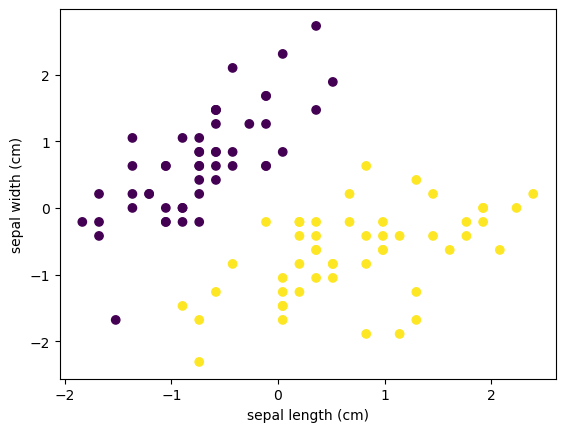

In [4]:
n = 100
selected_X, selected_y = select_n_points(data_X, data_y, n)
scaler = StandardScaler()
selected_X = scaler.fit_transform(selected_X)
_, ax = plt.subplots()
scatter = ax.scatter(selected_X[:, 0], selected_X[:, 1], c=selected_y)
ax.set(xlabel='sepal length (cm)', ylabel='sepal width (cm)')

In [5]:
# Define the plotting function
def plot_svm_decision_boundary(X, y, w, b, feature_x_idx, feature_y_idx):
    plt.figure(figsize=(10, 8))
    
    # Plot the two classes
    plt.scatter(X[y > 0][:, feature_x_idx], X[y > 0][:, feature_y_idx], c='b', label='Class 1')
    plt.scatter(X[y < 0][:, feature_x_idx], X[y < 0][:, feature_y_idx], c='r', label='Class -1')

    # Plot decision boundary
    x_min, x_max = X[:, feature_x_idx].min() - 1, X[:, feature_x_idx].max() + 1
    y_min, y_max = X[:, feature_y_idx].min() - 1, X[:, feature_y_idx].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    
    # Use only the selected features for the decision boundary
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = np.dot(grid, w[[feature_x_idx, feature_y_idx]]) + b
    Z = Z.reshape(xx.shape)
    
    plt.contour(xx, yy, Z, colors='k', levels=[0], alpha=0.5, linestyles=['-'])
    plt.contour(xx, yy, Z, colors='k', levels=[-1, 1], alpha=0.5, linestyles=['--'])
    
    plt.xlabel(f'Feature {feature_x_idx + 1}')
    plt.ylabel(f'Feature {feature_y_idx + 1}')
    plt.legend()
    plt.title('Hard Margin SVM Decision Boundary')
    plt.show()
    
# Define the modified plotting function to plot two decision boundaries
def plot_svm_decision_boundary_confrontation(X, y, w_1, b_1, w_2, b_2, feature_x_idx, feature_y_idx):
    plt.figure(figsize=(10, 8))
    
    # Plot the two classes
    plt.scatter(X[y > 0][:, feature_x_idx], X[y > 0][:, feature_y_idx], c='b', label='Class 1')
    plt.scatter(X[y < 0][:, feature_x_idx], X[y < 0][:, feature_y_idx], c='r', label='Class -1')

    # Create mesh grid for decision boundaries
    x_min, x_max = X[:, feature_x_idx].min() - 1, X[:, feature_x_idx].max() + 1
    y_min, y_max = X[:, feature_y_idx].min() - 1, X[:, feature_y_idx].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    # First model's decision boundary (Ground Truth) in orange with highlight effect (thicker and transparent)
    Z1 = np.dot(grid, w_1[[feature_x_idx, feature_y_idx]]) + b_1
    Z1 = Z1.reshape(xx.shape)
    ground_truth = plt.contour(xx, yy, Z1, colors='purple', levels=[0], alpha=0.3, linewidths=5, linestyles=['-'])
    plt.contour(xx, yy, Z1, colors='purple', levels=[-1, 1], alpha=0.3, linewidths=3, linestyles=['--'])
    
    # Second model's decision boundary (ODE Solution) in purple
    Z2 = np.dot(grid, w_2[[feature_x_idx, feature_y_idx]]) + b_2
    Z2 = Z2.reshape(xx.shape)
    ode_solution = plt.contour(xx, yy, Z2, colors='green', levels=[0], alpha=0.8, linewidths=2, linestyles=['-'])
    plt.contour(xx, yy, Z2, colors='green', levels=[-1, 1], alpha=0.8, linewidths=1.5, linestyles=['--'])
    
    # Add the two main lines to the legend
    h1, _ = ground_truth.legend_elements()
    h2, _ = ode_solution.legend_elements()
    plt.legend([h1[0], h2[0]], ['Ground Truth', 'ODE Solution'], loc='upper right')
    
    # Add labels, title, and show the plot
    plt.xlabel(f'Feature {feature_x_idx + 1}')
    plt.ylabel(f'Feature {feature_y_idx + 1}')
    plt.title('SVM Decision Boundaries (Ground Truth vs ODE Solution)')
    plt.show()

Time: 0.09312319755554199
Optimal objective value: 11.273241316406072
SCS solver iterations: 575
SCS solve time: 0.029813434
SCS setup time: 0.036204251
Optimal w:  [ 4.03251728 -2.50704747]
Optimal b:  [0.92736812]
Dual variables (Lagrange multipliers): [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          3.88718188  0.          0.
  0.          0.         -0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          7.38605975  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          5.62763749  0.          5.64560312
  0.          0.          0.          0.          0.          0.
  0.          0.      

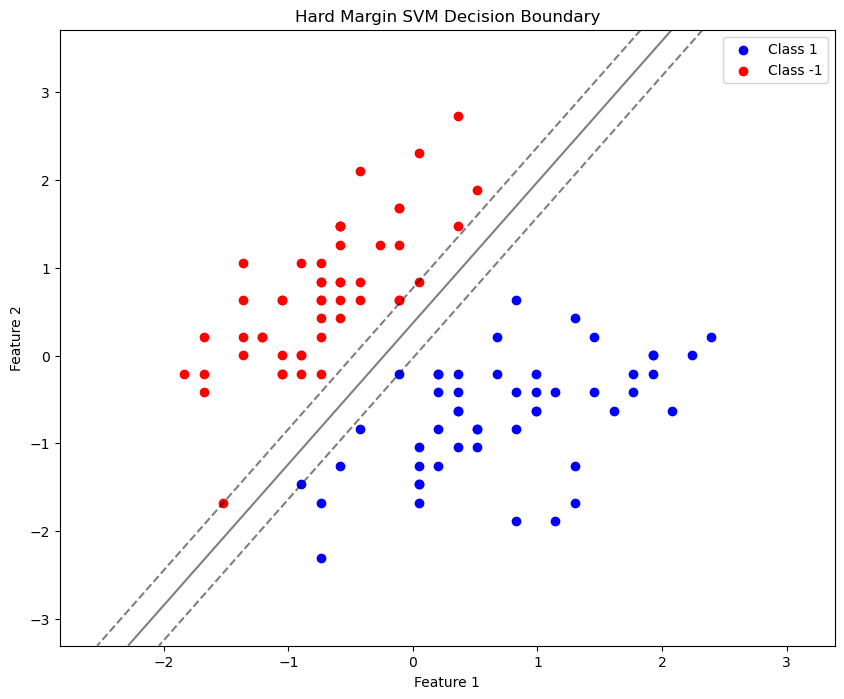

In [6]:
import cvxpy as cp
import numpy as np
import time

w = cp.Variable(2)
b = cp.Variable(1)

objective = cp.Minimize((1/2)*cp.norm(w, 2)**2)

constraints = [
    cp.multiply(selected_y, cp.matmul(selected_X, w) + b) >= 1,
]

problem = cp.Problem(objective, constraints)

t0 = time.time()
problem.solve(solver='SCS')
solve_time = time.time() - t0

# Get solver stats
solver_stats = problem.solver_stats
print('Time:', solve_time)
print('Optimal objective value:', problem.value)
print('SCS solver iterations:', solver_stats.num_iters)
print('SCS solve time:', solver_stats.solve_time)
print('SCS setup time:', solver_stats.setup_time)

# Get the values of the variables
print('Optimal w: ', w.value)
print('Optimal b: ', b.value)

# Get the dual variables
dual_variables = constraints[0].dual_value
print('Dual variables (Lagrange multipliers):', dual_variables)

g = [-selected_y[i] * (w.value @ selected_X[i] + b.value) + 1 for i in range(selected_y.shape[0])]
g_SCS = jnp.array(g).flatten()
print('Constraints:', g_SCS)

# Plotting
plot_svm_decision_boundary(selected_X, selected_y, w.value, b.value, 0, 1)

In [7]:
w.value

array([ 4.03251728, -2.50704747])

In [8]:
nw = selected_X.shape[1]
nb = 1
nx = nw + nb
nu = selected_X.shape[0]
NY = nx+nu

def f(x):
    w = x[:-1]
    output = (1/2) * jnp.linalg.norm(w, 2)**2
    return output

def g(x):
    w = x[:nw]
    b = x[nw]
    
    g = [-selected_y[i] * (w @ selected_X[i] + b) + 1 for i in range(selected_y.shape[0])]
    output = jnp.array(g)
    return output

df = fgrad(f) # jacobian of f
dg = jacrev(g) # jacobian of g

def P(xu): # projection mapping
    return xu

def ODE(t, xu):
    x, u = xu[:nx].reshape((nx, )), xu[nx:].reshape((nu, ))

    dx = df(x) + dg(x).T@jnp.clip(u+g(x), a_min=0)
    dx = -dx
    du = -u + jnp.clip(u+g(x), a_min=0)
    du = 0.5*du
    dxu = jnp.concatenate([dx, du], axis=0)
    return dxu

ODE = jit(ODE)

def evalutation(xu): # metric OuC(x_pred): check if inisde feasable region and return the objective value
    "return  f(x),    if g(x)<=0, f(x)=np.inf, if g(x)>0 "
    x, u= xu[:nx], xu[nx:]
    if (g(x)<=0.001).all():
        obj = f(x)
        #print('g(x) values:', g(x))
    else:
        obj = np.inf
        #print('g(x) values:', g(x))
    return obj

def constraints_diff(g_ODE, g_SCS):
    return jnp.abs(g_ODE - g_SCS).max()

In [9]:
def solve_ODE(xu0, T):
    sol = solve_ivp(ODE, [0., T], xu0, t_eval=np.arange(0, T, 0.01), method='BDF')
    result = P(sol.y[:, -1])
    print("objective:",evalutation(result))
    print("Constraints:",g(result[:nx]))
    diff = constraints_diff(g(result[:nx]), g_SCS)
    print("max diff:", diff.max(), "mean diff:", diff.mean())
    print("w diff:", jnp.abs(result[:nw] - w.value), "b diff:", jnp.abs(result[nw] - b.value))

    return sol, result

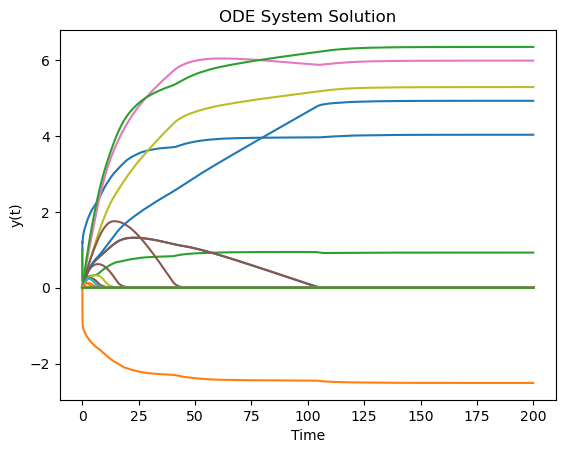

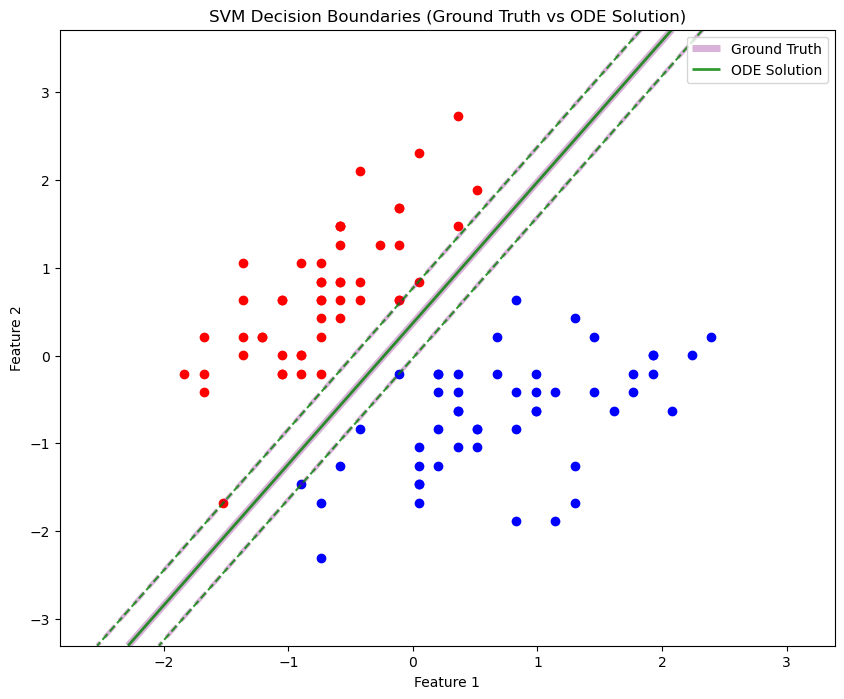

In [16]:
xu0 = jnp.zeros(NY)
xu0 = xu0.at[:nw + nb].set(1.0)

sol, result = solve_ODE(xu0, 100)

t_values = sol.t
y_values = sol.y

plt.plot(t_values, y_values.T)
plt.xlabel('Time')
plt.ylabel('y(t)')
plt.title('ODE System Solution')
plt.show()

plot_svm_decision_boundary_confrontation(selected_X, selected_y, w.value, b.value, result[:data_X.shape[1]], result[data_X.shape[1]], 0, 1)

In [11]:
sol, result = solve_ODE(xu0, 20)

objective: inf
Constraints: [-2.1980145  -2.0060852  -1.2016213  -6.6699896  -3.163026   -3.943802
 -0.79700994  0.02344722 -4.4722157  -6.777798   -6.5017476  -0.8574433
  0.02344722 -3.247147   -2.8709822   0.17569573 -2.9787908  -1.8378432
 -6.2256975  -7.282524   -2.090206   -1.8141556  -1.3017356  -4.3880944
 -1.3698632  -2.4426832  -2.2744412  -1.3094299  -7.582262   -3.1470327
 -1.8301489  -2.994784   -2.5344985   0.19938333 -2.0060852  -0.43683854
 -3.507204   -1.3698632  -3.4153888  -6.1415763  -1.3858566  -2.129887
 -0.8574433  -3.338962   -2.1903203  -4.3039737  -2.5344985  -6.2256975
 -0.16848229 -3.4390764  -3.6914394  -6.585869   -0.07666712 -8.0869875
 -5.5290422  -2.7868612  -4.196165    0.10756817 -2.5504918   0.15494339
 -1.2857423  -0.5286537  -0.3130366  -2.994784   -1.0333794  -3.338962
 -1.193927   -3.4835165  -3.0024784  -1.2857423  -1.1175003  -3.078905
 -2.090206   -3.247147   -4.143426   -3.0392241  -4.3721013  -7.666383
 -0.8414499  -1.6459136  -3.338962   -2

In [12]:
sol, result = solve_ODE(xu0, 50)

objective: inf
Constraints: [-2.5301375  -2.3381858  -1.4402041  -7.815238   -3.784689   -4.6963506
 -1.0633842  -0.02814396 -5.299565   -7.904374   -7.6096067  -1.1798797
 -0.02814396 -3.8875046  -3.352663    0.04022899 -3.441799   -2.1325545
 -7.3148394  -8.521268   -2.4410017  -2.1462343  -1.6802783  -5.196749
 -1.6458356  -2.989523   -2.7838914  -1.52934    -8.802356   -3.6474304
 -2.2834928  -3.5790575  -2.9414003   0.02654916 -2.3381858  -0.6658011
 -4.0450134  -1.6458356  -4.093136   -7.2120237  -1.783094   -2.5645802
 -1.1798797  -3.839382   -2.6810758  -5.0939336  -2.9414003  -7.3148394
 -0.22009555 -4.0794563  -4.387903   -7.7124224  -0.26821813 -9.41925
 -6.5059934  -3.2498474  -5.0047975   0.07467175 -3.0786588   0.0473121
 -1.5430199  -0.6176785  -0.43940678 -3.5790575  -1.2345728  -3.839382
 -1.5911424  -4.0586934  -3.4281192  -1.5430199  -1.3373885  -3.681873
 -2.4410017  -3.8875046  -4.737364   -3.5582945  -5.0594907  -8.905171
 -1.0426211  -1.9406029  -3.839382   -3.33

In [17]:
sol, result = solve_ODE(xu0, 150)

objective: 11.2603245
Constraints: [-2.7347572  -2.5242825  -1.5774126  -8.205231   -3.9972277  -4.943991
 -1.1568307  -0.10462205 -5.5752025  -8.310521   -7.994863   -1.2619084
 -0.10462205 -4.1024117  -3.5762303   0.00040752 -3.6815207  -2.3139143
 -7.679204   -8.941627   -2.6294668  -2.313808   -1.7879354  -5.4700184
 -1.7877809  -3.155542   -2.9451735  -1.6827031  -9.257392   -3.8918889
 -2.4191465  -3.7868595  -3.1554937   0.00051393 -2.5242825  -0.7359878
 -4.3127317  -1.7877809  -4.31278    -7.57402    -1.8931196  -2.7349117
 -1.2619084  -4.1023636  -2.8399894  -5.364834   -3.1554937  -7.679204
 -0.3150967  -4.312886   -4.628439   -8.100047   -0.31514484 -9.888496
 -6.8376245  -3.471046   -5.2595434   0.00056207 -3.2608323   0.0007749
 -1.6825967  -0.7359396  -0.52535856 -3.7868595  -1.3670443  -4.1023636
 -1.6826448  -4.3126254  -3.681627   -1.6825967  -1.4722285  -3.8920436
 -2.6294668  -4.1024117  -5.0492334  -3.7865984  -5.3646793  -9.362576
 -1.1565697  -2.1034396  -4.10236

In [15]:
sol, result = solve_ODE(xu0, 200)

objective: 11.272978
Constraints: [-2.7367847  -2.5262692  -1.5789171  -8.210428   -3.9999378  -4.947303
 -1.1578559  -0.10524408 -5.578875   -8.31568    -7.9999003  -1.263133
 -0.10524408 -4.105202   -3.5788982   0.00002453 -3.6841495  -2.3157408
 -7.68412    -8.947265   -2.6315334  -2.3157537  -1.7894411  -5.473611
 -1.7894455  -3.15785    -2.9473217  -1.6841685  -9.263032   -3.894678
 -2.4210134  -3.7894094  -3.1578414   0.00001162 -2.5262692  -0.736812
 -4.315722   -1.7894455  -4.3157306  -7.578856   -1.8947053  -2.7367802
 -1.263133   -4.1051936  -2.8420575  -5.3683467  -3.1578414  -7.68412
 -0.31575957 -4.3157177  -4.6315103  -8.105165   -0.3157681  -9.894617
 -6.8420196  -3.473634   -5.2630954   0.00002012 -3.2631013  -0.0000057
 -1.6841813  -0.7368035  -0.5263009  -3.7894094  -1.3683888  -4.1051936
 -1.6841898  -4.315735   -3.6841366  -1.6841813  -1.473653   -3.8946736
 -2.6315334  -4.105202   -5.0525455  -3.7894268  -5.368351   -9.368296
 -1.1578733  -2.1052253  -4.1051936  -3

In [15]:
sol, result = solve_ODE(xu0, 1000)

objective: 5.072049
Constraints: [-0.27189207 -2.6349452  -2.998314   -4.2705226  -0.8168406  -2.4531562
 -1.4537876  -1.7263142  -1.6354719  -1.0894717  -6.087151   -5.0874686
 -1.7264187  -3.0885224  -0.45347187 -3.3611536  -2.0897875  -2.6348405
 -0.7267365  -2.2708383  -5.3601     -3.4519958  -1.2712606   0.000001
 -2.6349452  -2.815996   -1.181052   -1.3628409  -2.7258918  -1.362312
 -0.9993676  -2.7250493  -1.7263142  -6.632204    0.00073904 -2.4525228
 -2.362314   -1.0902097  -1.4530495   0.00031469 -1.8164183  -2.5434694
 -3.542838   -1.7264187  -2.4525228  -2.1799963  -0.27242097 -1.5438918
 -1.6354719  -2.0897875 ]
max diff: 0.0041823387 mean diff: 0.0041823387
w diff: [0.00138719 0.00073533] b diff: [0.00054339]


In [16]:
sol, result = solve_ODE(xu0, 2000)

objective: 5.0770826
Constraints: [-0.27274045 -2.6363783  -3.000017   -4.2727513  -0.8181984  -2.454559
 -1.4545532  -1.7272822  -1.6363726  -1.0909272  -6.0909557  -5.09095
 -1.727282   -3.0909386  -0.45455986 -3.3636672  -2.0909207  -2.6363785
 -0.72727656 -2.272752   -5.363679   -3.454577   -1.2727463   0.00000052
 -2.6363783  -2.8182096  -1.1818246  -1.3636438  -2.7272878  -1.3636557
 -1.0000054  -2.7273002  -1.7272822  -6.6364136  -0.00001168 -2.4545712
 -2.3636496  -1.090915   -1.4545655   0.00000016 -1.818204   -2.5454807
 -3.5454867  -1.727282   -2.4545712  -2.1818423  -0.2727285  -1.5454751
 -1.6363726  -2.0909207 ]
max diff: 5.9962273e-05 mean diff: 5.9962273e-05
w diff: [0.00000198 0.0000223 ] b diff: [0.00001128]


In [18]:
w_ode = result[:nw]
b_ode = result[nw]

# 3. The method

In [19]:
T=150.0

In [20]:
def g_batch(x):
    w = x[:, :nw]  # Extract w for each sample in the batch
    b = x[:, nw]   # Extract b for each sample in the batch

    # Compute g for each batch sample (2048) and constraint (10) using NumPy
    g = [[-selected_y[j] * (w[i] @ selected_X[j] + b[i]) + 1 for j in range(selected_y.shape[0])] for i in range(x.shape[0])]
    
    output = np.array(g)
    return output

In [21]:
class FNN(nn.Module):
    def __init__(self, y0):
        self.y0 = torch.tensor(y0, dtype=torch.float)
        if CUDA:
            self.y0 = self.y0.cuda()
        super(FNN, self).__init__()
        self.linear1 = nn.Linear(1, NEURONS).cuda()
        self.linearL = []
        for _ in range(LAYERS-1):
            self.linearL.append(nn.Linear(NEURONS, NEURONS).cuda())
        self.linear2 = nn.Linear(NEURONS, NY).cuda()

    def forward(self, x):
        t = x.cuda()
        x = torch.tanh(self.linear1(x))
        for i in range(LAYERS-1):
            x = torch.tanh(self.linearL[i](x))
        x = self.linear2(x)
        x = self.y0 + (1 - torch.exp(-(t-0)))*x
        return x


class NN_NOP:
    def __init__(self, y0, time_range, P, ODE, C_epsilon): # P: projection mapping, ODE, C_epsilon: OuC metric
        self.y0 = np.array(y0)
        self.time_range = time_range # [0, 10]
        self.T = time_range[-1] # T=10
        self.P = P
        self.ODE = ODE
        self.C_epsilon = C_epsilon
        self.vODE = vmap(ODE, in_axes=(0, 0), out_axes=0)
        #self.numerical_method() # solve analyicallly the ODE

    def numerical_method(self):
        sol = solve_ivp(self.ODE, self.time_range, self.y0, method=NUMERICAL_METHOD)
        self.y_T_ODE = sol.y[:, -1] # get last value of the solution
        self.y_T_ODE = self.P(self.y_T_ODE) # project it
        self.y_T_ODE = np.array(self.y_T_ODE)
        self.epsilon_ODE = self.C_epsilon(self.y_T_ODE) # calculate OuC (f(x))

    def NN_method(self, weights=None, t_L=None):
        """
        train the nn, store the following four

        L_loss:  list, loss of batch during training
        L_epsilon: list, epsilon_best during training
        L_y_T: list, yT during training
        net_best:  the best neural network model during training
        """
        net = FNN(self.y0)
        if weights is not None:
            net.load_state_dict(weights.state_dict())
        if CUDA:
            net = net.cuda()
            
        optimizer = Adam(net.parameters(), lr=LR) # ========> 0.001 not looks good
        i = 0
        L_loss = []
        L_epsilon = []
        L_epsilon_curr = []
        L_y_T = []
        L_y_T_curr = []
        #L_y_iterations = []
        while True:
            # Update, L_epsilon, L_yT, net_best
            T = self.T*torch.ones((1, 1), dtype=torch.float)
            if CUDA:
                T = T.cuda()
            y_T = self.P_multiple(T, net) # get the output of the nn at T (last time)
            L_y_T_curr.append(y_T)

            epsilon_current = self.C_epsilon(y_T) # calculate OuC (f(x))
            L_epsilon_curr.append(epsilon_current)
            if i==0: # if first iteration
                epsilon_best = epsilon_current
                y_T_best = y_T
                #y_T_error = np.linalg.norm(self.y_T_ODE-y_T_best, ord=2)
                net_best = deepcopy(net)
                #L_y_iterations.append(self.y_iteration(net_best))
            # if i==10:
            #     L_y_iterations.append(self.y_iteration(net_best))
            # if i==20:
            #     L_y_iterations.append(self.y_iteration(net_best))
            # if i==ITERATIONS-1:
            #L_y_iterations.append(self.y_iteration(net_best)) # store the output of the best nn across the time
            if epsilon_current < epsilon_best:
                epsilon_best = epsilon_current
                y_T_best = y_T
                #y_T_error = np.linalg.norm(self.y_T_ODE-y_T_best, ord=2)
                net_best = deepcopy(net)
            L_epsilon.append(epsilon_best) # store the best OuC
            L_y_T.append(y_T_best) # store the best output of the nn at T

            # TRAIN MODEL
            # Prepare input t, torch.tensor (NBATCH, 1)
            if t_L is not None:
                t = t_L[i]
            else:
                t = np.random.uniform(0, self.T, (NBATCH, 1))
                #t = np.random.uniform(0, 1, (NBATCH, 1))
                #t = self.T * (t ** 2)  # Where alpha > 1 biases towards smaller values
            t = torch.tensor(t, dtype=torch.float, requires_grad=True)
            if CUDA:
                t = t.cuda()
            # Learning, L_loss
            loss = self.loss_compute(t, net)
            loss.backward()
            L_loss.append(loss.item())
            optimizer.step()
            optimizer.zero_grad()
            # Monitor
            if i%100==0:
            # if i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99]:
                #print(f'T: {self.T}, y_T_ODE: {self.y_T_ODE.round(4)}, epsilon_ODE: {self.epsilon_ODE :.4f},  Iteration: {i}, Loss: {loss.item() :.4f},  epsilon_best: {epsilon_best :.4f}, y_T: {y_T_best.round(4)}, ||y_T_ODE-y_T_best||_2: {y_T_error :.4f}')
                #print(f'T: {self.T}, Iteration: {i}, Loss: {loss.item() :.4f},  epsilon_best: {epsilon_best :.4f}, y_T: {y_T_best.round(4)}')
                pass
            i = i+1
            
            torch.cuda.empty_cache()
            
            if i==ITERATIONS:
                break

        return L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss

    def loss_compute(self, t, net):
        # nn output xu, torch.tensor (NBATCH, nxu)
        y = net(t)

        # => Get ODE derivatives
        # True dxu, torch.tensor (NBATCH, nxu)
        t_cpu = t.cpu().detach().numpy()
        y_cpu = y[:, :].cpu().detach().numpy()
        dy = self.vODE(t_cpu, y_cpu)
        dy = np.array(dy)
        
        dy = torch.tensor(dy, dtype=torch.float)
        if CUDA:
            dy = dy.cuda()

        # => Get NN derivatives (autograd)
        # Predicted pdxu, torch.tensor (NBATCH, nxu)
        pdy = []
        for j in range(NY): # for all outputs node (for all variables)
            # y[:, [j]]: outputs of the nn for the j-th variable (all t of the batch), t: inputs of the nn, grad_outputs: scale the gradients to facilitate the compuation of the jacobian, Craete_graph: to compute higer order derivatives
            pdyi = grad(y[:, [j]], t, grad_outputs=torch.ones_like(y[:, [j]]), create_graph=True)[0] # torch autograd shape [NBATCH, 1]
            pdy.append(pdyi)
        pdy = torch.cat(pdy, dim=1) # for makning it a tensor: [NBATCH, NY]
        #pdy = torch.cat(pdy, dim=1) # for makning it a tensor: [NBATCH, NY]

        # 1. Dynamics loss
        # Compute loss, torch.tensor a float
        dynamics_loss = mse(dy, pdy) # [NBATCH, NY]
        dynamics_loss = torch.sum(dynamics_loss, axis=1) # [NBATCH]
        dynamics_loss = torch.exp(-WEIGTHING*(t / T).detach().reshape((-1, )))*dynamics_loss  # proprity smaller t
        dynamics_loss = torch.mean(dynamics_loss, axis=0)
        
        # 2. Constraint violation penalty with smooth weighting
        x = y[:, :nx].cpu().detach().numpy()
        constraint_loss = torch.tensor(np.maximum(g_batch(x), 0), dtype=torch.float).cuda()
        constraint_loss = torch.sum(constraint_loss, axis=1) # [NBATCH]
        constraint_loss = torch.exp(-WEIGTHING * (1 - t / T).detach().reshape((-1,))) * constraint_loss
        constraint_loss = torch.mean(constraint_loss)
        
        # 4. Total loss
        loss = dynamics_loss + constraint_loss * CONSTRAINT_WEIGHT
        
        return loss

    def P_multiple(self, t, net): # get the projection of the output of the nn (for multiple t)
        y = net(t)
        y = y.reshape((-1, )).cpu().detach().numpy()
        output = self.P(y)
        output = np.array(output)
        return output

    def y_iteration(self, net): # get the ODE system estiamtion across the time
        # For L_y
        t = torch.arange(0, self.T, 0.1).reshape((-1, 1))
        if CUDA:
            t = t.cuda()
        y = [self.P_multiple(t[i].reshape((1,1)), net) for i in range(t.shape[0])]
        y = torch.tensor(np.array(y)).cpu().detach().numpy()

        return y # [T, NY]


In [22]:
y0 = np.zeros(NY)
y0[:nw + nb] = 1.0

In [23]:
NBATCH = 512 # 512
ITERATIONS = 1000
NEURONS = 400
LAYERS = 2
LR = 0.001
CONSTRAINT_WEIGHT = 0.2
WEIGTHING = 4

In [24]:
def try_layers(l_list, n, lr):
     NEURONS = n
     LR = lr
     res = []
     for l in l_list:
          LAYERS = l
          example = NN_NOP(y0, [0, T], P, ODE, evalutation) # init
          L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss = example.NN_method() # train
          mse_ = get_error({'net': net_best})
          print('LAYERS:', l, 'NEURONS:', n, 'LR:', lr, 'epsilon:', L_epsilon[-1], 'MSE solution:', mse_)
          res.append({'layers': l, 'neurons': n, 'lr': lr, 'net': net_best, 'L_epsilon': L_epsilon, 'L_epsilon_curr': L_epsilon_curr, 'MSE soltion: ': mse_})
     return res

def try_neurons(n_list, l, lr):
     LAYERS = l
     LR = lr
     res = []
     for n in n_list:
          NEURONS = n
          example = NN_NOP(y0, [0, T], P, ODE, evalutation) # init
          L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss = example.NN_method() # train
          mse_ = get_error({'net': net_best})
          print('LAYERS:', l, 'NEURONS:', n, 'LR:', lr, 'epsilon:', L_epsilon[-1], 'MSE solution:', mse_)
          res.append({'layers': l, 'neurons': n, 'lr': lr, 'net': net_best, 'L_epsilon': L_epsilon, 'L_epsilon_curr': L_epsilon_curr, 'MSE soltion: ': mse_})
     return res

def try_lr(lr_list, l, n):
     LAYERS = l
     NEURONS = n
     res = []
     for lr in lr_list:
          LR = lr
          example = NN_NOP(y0, [0, T], P, ODE, evalutation) # init
          L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss = example.NN_method() # train
          mse_ = get_error({'net': net_best})
          print('LAYERS:', l, 'NEURONS:', n, 'LR:', lr, 'epsilon:', L_epsilon[-1], 'MSE solution:', mse_)
          res.append({'layers': l, 'neurons': n, 'lr': lr, 'net': net_best, 'L_epsilon': L_epsilon, 'L_epsilon_curr': L_epsilon_curr, 'MSE soltion: ': mse_})
     return res

def plot_results(res, y_max=50):
    fig, axes = plt.subplots(1, len(res), figsize=(20, 6))
    y_min = 0
    for i in range(len(res)):
        # Plot on the first subplot
        axes[i].plot(res[i]['L_epsilon'], marker='o', linestyle='-', label='OuC metric best', markersize=1)
        axes[i].plot(res[i]['L_epsilon_curr'], marker='o', linestyle='-', label='OuC metric current', markersize=1)
        axes[i].set_xlabel('iteration')
        axes[i].set_ylabel('OuC metric')
        axes[i].set_title(f'l={res[i]["layers"]}, n={res[i]["neurons"]}, lr={res[i]["lr"]}')
        axes[i].legend()
        axes[i].grid(True)
        axes[i].set_ylim(y_min, y_max)
        axes[i].set_xlim(0, ITERATIONS)
    # Adjust layout to prevent overlapping
    plt.tight_layout()
    # Show the plot
    plt.show()

def plot_result_confrontation(res):
     for r in res:
          plt.plot(r['L_epsilon'], marker='o', linestyle='-', label=f'l={r["layers"]}, n={r["neurons"]}, lr={r["lr"]}', markersize=1)
     # Add labels, title, legend and grid
     plt.xlabel('iteration')
     plt.ylabel('OuC metric')
     plt.title('Numbers of layers')
     plt.legend()  # Show the legend to distinguish the datasets
     plt.grid(True)
     plt.show()

def plot_hyperplane(r):
     net = r['net']
     epsilon = net(torch.tensor([[T]]).cuda()).cpu().detach().numpy()
     w_net = epsilon[0][:selected_X.shape[1]]
     b_net = epsilon[0][selected_X.shape[1]]
     # Plotting
     plt.figure(figsize=(10, 8))
     plt.scatter(selected_X[selected_y > 0][:, 0], selected_X[selected_y > 0][:, 1], c='b', label='Class 1')
     plt.scatter(selected_X[selected_y < 0][:, 0], selected_X[selected_y < 0][:, 1], c='r', label='Class -1')

     # Plot the decision boundary
     x_min, x_max = selected_X[:, 0].min() - 1, selected_X[:, 0].max() + 1
     y_min, y_max = selected_X[:, 1].min() - 1, selected_X[:, 1].max() + 1
     xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
     Z = np.dot(np.c_[xx.ravel(), yy.ravel()], w_net) + b_net
     Z = Z.reshape(xx.shape)
     plt.contour(xx, yy, Z, colors='k', levels=[0], alpha=0.5, linestyles=['-'])

     # Plot the margins
     plt.contour(xx, yy, Z, colors='k', levels=[-1, 1], alpha=0.5, linestyles=['--'])

     plt.xlabel('Feature 1')
     plt.ylabel('Feature 2')
     plt.legend()
     plt.title('Hard Margin SVM Decision Boundary')
     plt.show()

def print_error(r):
     net = r['net']
     epsilon = net(torch.tensor([[T]]).cuda()).cpu().detach().numpy()
     # Split epsilon into weights and bias
     w_net = epsilon[0][:selected_X.shape[1]]  # All weights
     b_net = epsilon[0][selected_X.shape[1]]   # Bias

     # Calculate absolute differences for weights and bias
     w_abs_diff = np.abs(w_ode - w_net)         # Vector for all weights
     b_abs_diff = np.abs(b_ode - b_net)      # Single value for bias

     # Calculate squared differences
     w_sq_diff = w_abs_diff ** 2               # Vector for squared differences of weights
     b_sq_diff = b_abs_diff ** 2               # Squared difference for bias

     # Calculate the Mean Squared Error (MSE)
     mse_ = (np.sum(w_sq_diff) + b_sq_diff) / (len(w_sq_diff) + 1)

     # Print the absolute differences for all weights and bias
     print('w absolute differences:', w_abs_diff)
     print('b absolute difference:', b_abs_diff)

     # Print the MSE
     print('\nMSE between the two solutions:', mse_)

def get_error(r):
     net = r['net']
     epsilon = net(torch.tensor([[T]], dtype=torch.float32).cuda()).cpu().detach().numpy()
     # Split epsilon into weights and bias
     w_net = epsilon[0][:selected_X.shape[1]]  # All weights
     b_net = epsilon[0][selected_X.shape[1]]   # Bias

     # Calculate absolute differences for weights and bias
     w_abs_diff = np.abs(w_ode - w_net)         # Vector for all weights
     b_abs_diff = np.abs(b_ode - b_net)      # Single value for bias

     # Calculate squared differences
     w_sq_diff = w_abs_diff ** 2               # Vector for squared differences of weights
     b_sq_diff = b_abs_diff ** 2               # Squared difference for bias

     # Calculate the Mean Squared Error (MSE)
     mse_ = (np.sum(w_sq_diff) + b_sq_diff) / (len(w_sq_diff) + 1)

     return mse_

In [ ]:
NBATCH = 512 # 512
ITERATIONS = 5000
res_learning_rate = try_lr([0.001, 0.01, 0.1], 2, 200)
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

In [81]:
net = res_learning_rate[1]['net']

In [82]:
res = net(torch.tensor([T]).cuda()).cpu().detach().numpy()

In [83]:
g(res[:nx])

Array([-0.00112519, -0.00776384, -0.15641929, -1.3194852 , -0.00774805,
       -2.4825351 , -0.54631025, -0.6289402 , -0.5529489 , -0.77097285],      dtype=float32)

In [ ]:
plot_svm_decision_boundary_confrontation(selected_X, selected_y, w_ode, b_ode, res[:data_X.shape[1]], res[data_X.shape[1]], 0, 1)

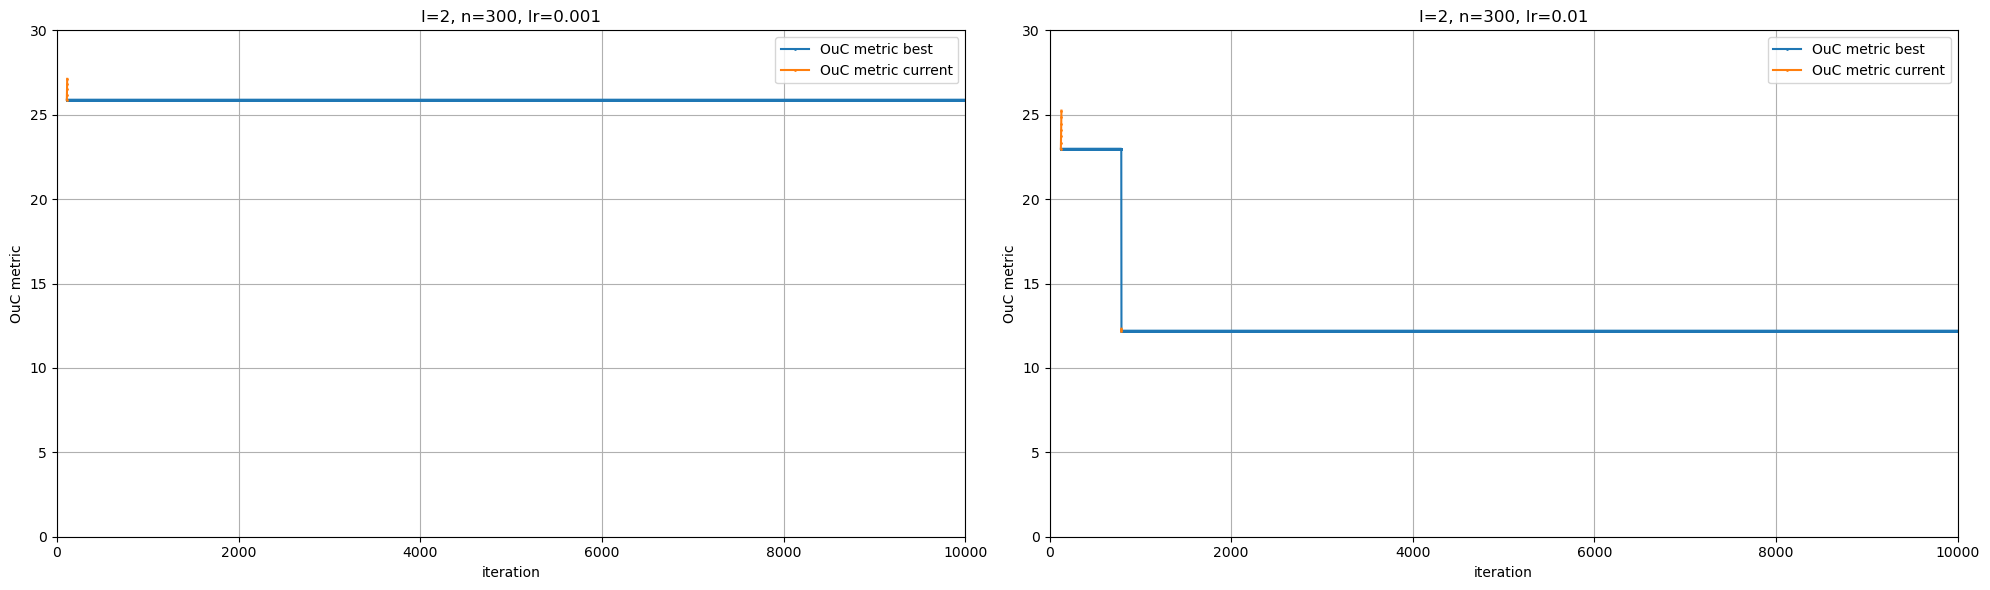

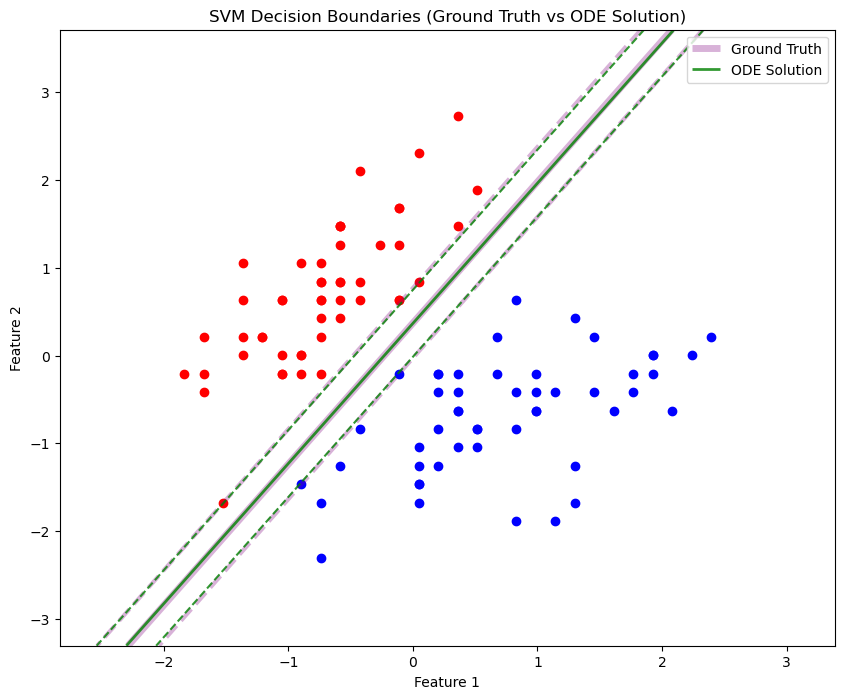

In [29]:
CONSTRAINT_WEIGHT = 0.2
WEIGTHING = 4
NBATCH = 512 # 512
ITERATIONS = 10000
res_1= try_lr([0.001, 0.01], 2, 300)
plot_results(res_1, y_max=30)
net = res_1[1]['net']
res = net(torch.tensor([T]).cuda()).cpu().detach().numpy()
g(res[:nx])
plot_svm_decision_boundary_confrontation(selected_X, selected_y, w_ode, b_ode, res[:data_X.shape[1]], res[data_X.shape[1]], 0, 1)

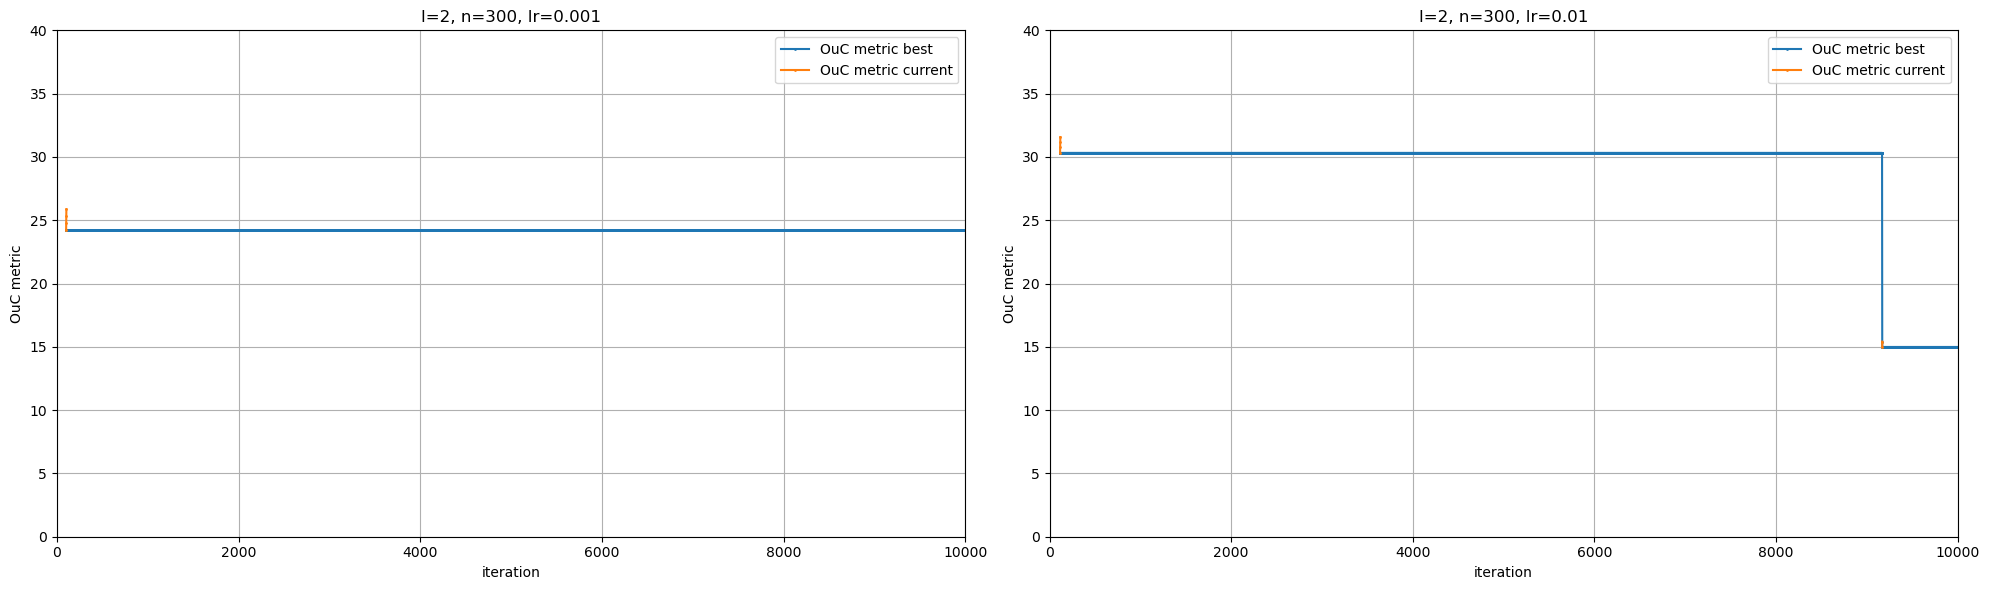

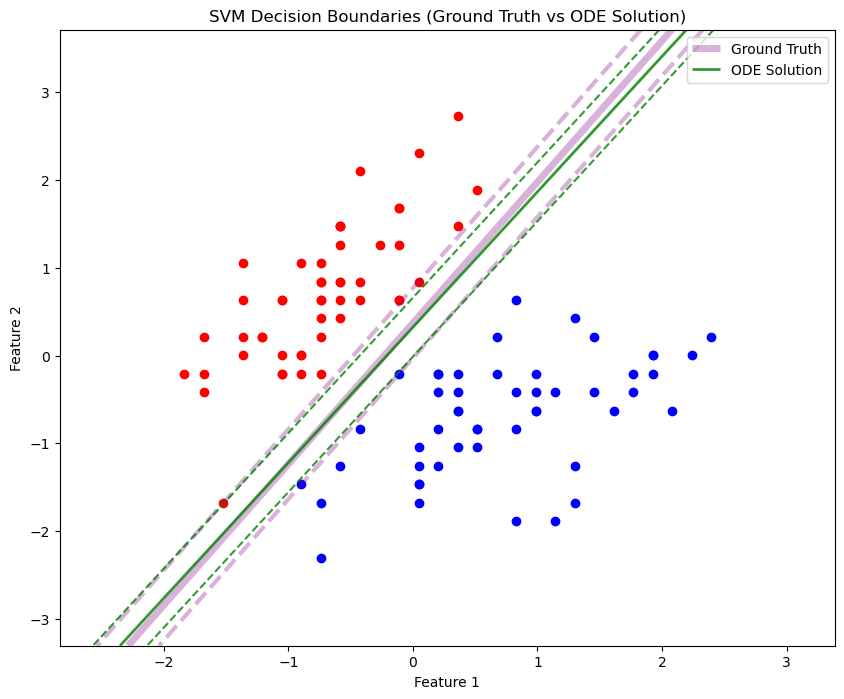

In [31]:
CONSTRAINT_WEIGHT = 0.2
WEIGTHING = 2
res_2= try_lr([0.001, 0.01], 2, 300)
plot_results(res_2, y_max=40)
net = res_2[1]['net']
res = net(torch.tensor([T]).cuda()).cpu().detach().numpy()
g(res[:nx])
plot_svm_decision_boundary_confrontation(selected_X, selected_y, w_ode, b_ode, res[:data_X.shape[1]], res[data_X.shape[1]], 0, 1)

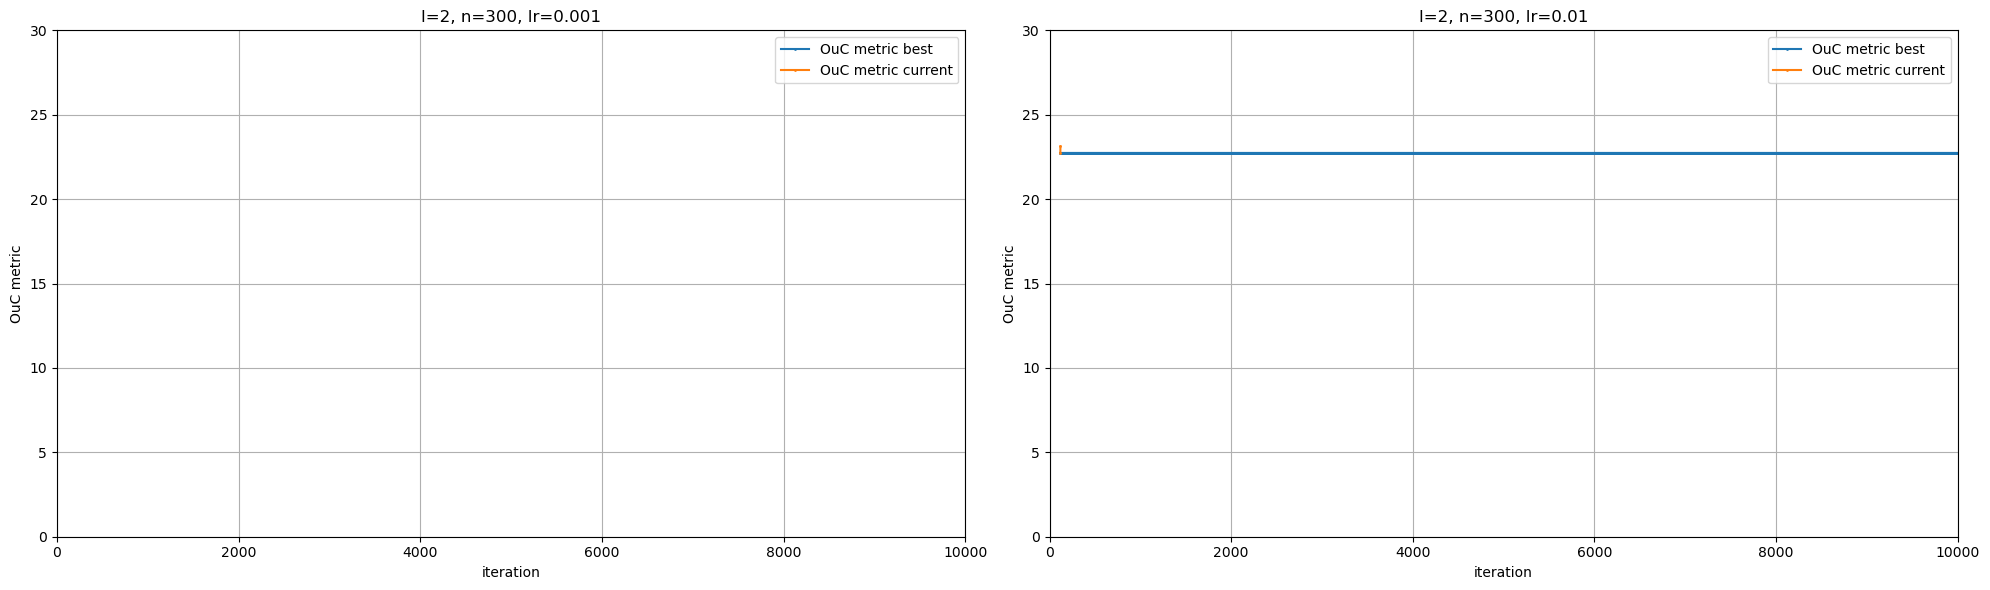

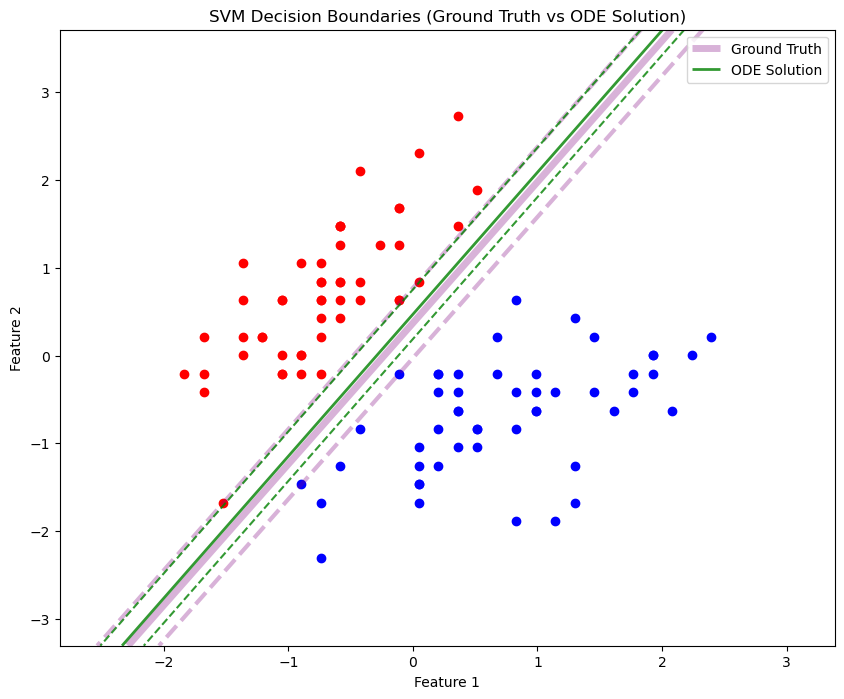

In [32]:
CONSTRAINT_WEIGHT = 0.5
WEIGTHING = 4
res_3= try_lr([0.001, 0.01], 2, 300)
plot_results(res_3, y_max=30)
net = res_3[1]['net']
res = net(torch.tensor([T]).cuda()).cpu().detach().numpy()
g(res[:nx])
plot_svm_decision_boundary_confrontation(selected_X, selected_y, w_ode, b_ode, res[:data_X.shape[1]], res[data_X.shape[1]], 0, 1)

In [ ]:
CONSTRAINT_WEIGHT = 0.5
WEIGTHING = 2
res_4= try_lr([0.001, 0.01], 2, 300)
plot_results(res_4, y_max=10)
net = res_4[1]['net']
res = net(torch.tensor([T]).cuda()).cpu().detach().numpy()
g(res[:nx])
plot_svm_decision_boundary_confrontation(selected_X, selected_y, w_ode, b_ode, res[:data_X.shape[1]], res[data_X.shape[1]], 0, 1)

In [ ]:
CONSTRAINT_WEIGHT = 1
WEIGTHING = 4
res_5= try_lr([0.001, 0.01], 2, 300)
plot_results(res_5, y_max=10)
net = res_5[1]['net']
res = net(torch.tensor([T]).cuda()).cpu().detach().numpy()
g(res[:nx])
plot_svm_decision_boundary_confrontation(selected_X, selected_y, w_ode, b_ode, res[:data_X.shape[1]], res[data_X.shape[1]], 0, 1)

In [ ]:
CONSTRAINT_WEIGHT = 1
WEIGTHING = 2
res_6= try_lr([0.001, 0.01], 2, 300)
plot_results(res_6, y_max=10)
net = res_6[1]['net']
res = net(torch.tensor([T]).cuda()).cpu().detach().numpy()
g(res[:nx])
plot_svm_decision_boundary_confrontation(selected_X, selected_y, w_ode, b_ode, res[:data_X.shape[1]], res[data_X.shape[1]], 0, 1)

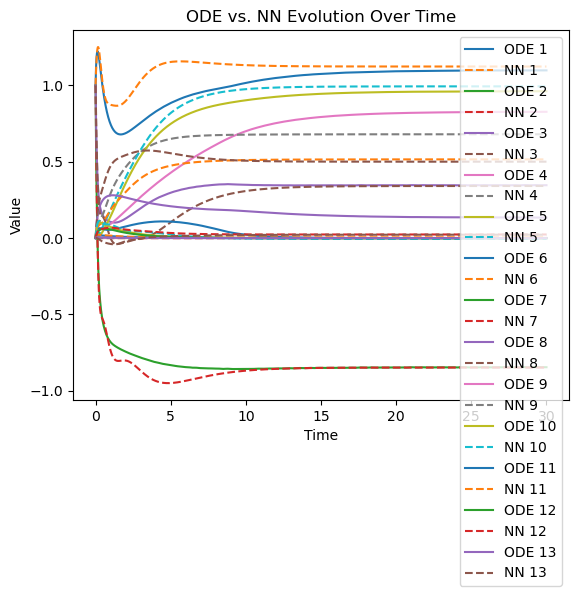

In [85]:
net = res_learning_rate[0]['net']
t_span = [0, T]
t_eval = np.linspace(t_span[0], t_span[1], 1000)
sol = solve_ivp(ODE, t_span, y0, method=NUMERICAL_METHOD, t_eval=t_eval)
y_ODE = sol.y

t_torch = torch.tensor(t_eval.reshape((-1, 1)), dtype=torch.float).cuda()

y_nn = net(t_torch)
y_nn = y_nn.T.cpu().detach().numpy()

# Create a figure and axes
fig, ax = plt.subplots()

# Iterate and plot
for i in range(y_ODE.shape[0]):
    ax.plot(t_eval, y_ODE[i], label=f'ODE {i+1}')  # Adjust label as needed
    ax.plot(t_eval, y_nn[i], label=f'NN {i+1}', linestyle='--')  # Adjust label and style

# Add labels, legend, and title
ax.set_xlabel('Time')
ax.set_ylabel('Value')
ax.set_title('ODE vs. NN Evolution Over Time')
ax.legend()

# Display the plot
plt.show()

In [ ]:
T=50
NBATCH = 2048 # 512
ITERATIONS = 5000
res_learning_rate = try_lr([0.0001, 0.001, 0.01, 0.1], 2, 200)
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

LAYERS: 1 NEURONS: 400 LR: 0.001 epsilon: 1.1052916 MSE solution: 0.0910762032805955
LAYERS: 2 NEURONS: 400 LR: 0.001 epsilon: 0.77713764 MSE solution: 0.015304028200252603
LAYERS: 3 NEURONS: 400 LR: 0.001 epsilon: 0.9250497 MSE solution: 0.030800409698648116
LAYERS: 4 NEURONS: 400 LR: 0.001 epsilon: 0.87401 MSE solution: 0.016325091526455678
LAYERS: 5 NEURONS: 400 LR: 0.001 epsilon: 0.657731 MSE solution: 0.011343299603153003


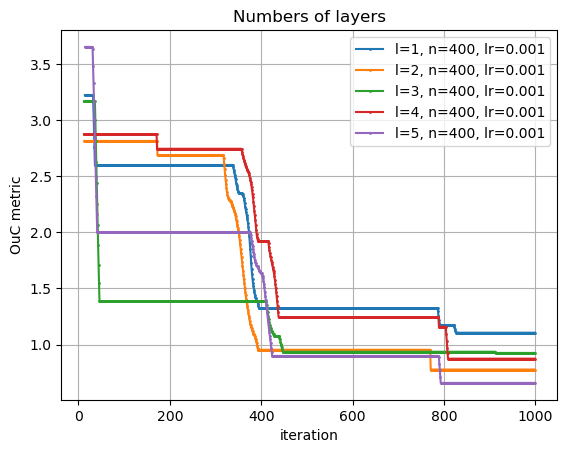

In [53]:
res_layers = try_layers([1, 2, 3, 4, 5], 400, 0.001)
plot_results(res_layers, y_max=10)
plot_result_confrontation(res_layers)

LAYERS: 2 NEURONS: 100 LR: 0.001 epsilon: 0.7583888 MSE solution: 0.03606375842315449
LAYERS: 2 NEURONS: 200 LR: 0.001 epsilon: 0.86000186 MSE solution: 0.005976157490933457
LAYERS: 2 NEURONS: 300 LR: 0.001 epsilon: 0.7569158 MSE solution: 0.00660960942401389
LAYERS: 2 NEURONS: 400 LR: 0.001 epsilon: 0.81032944 MSE solution: 0.05636416955606193
LAYERS: 2 NEURONS: 500 LR: 0.001 epsilon: 0.721496 MSE solution: 0.009243793995327905


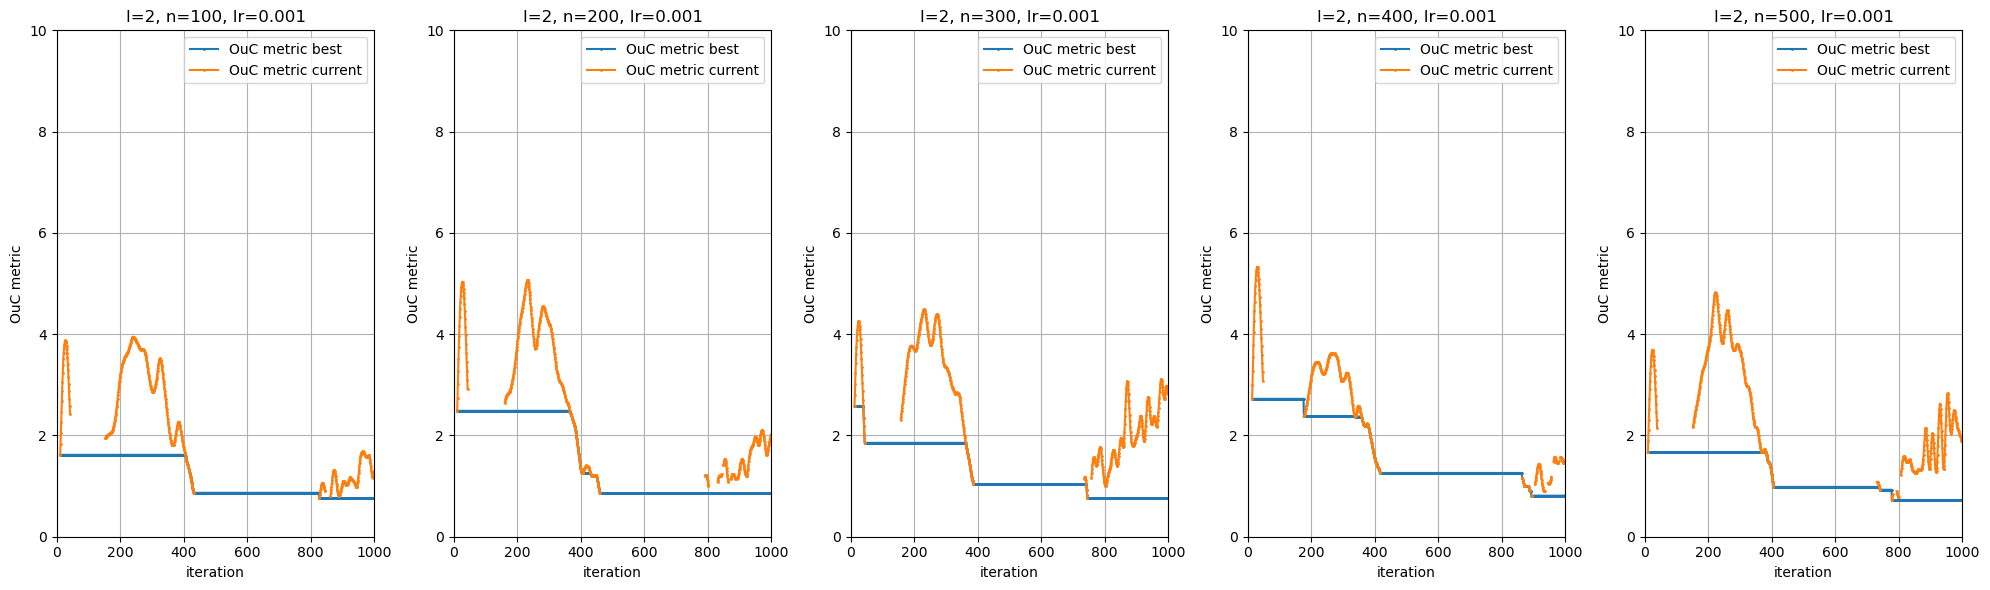

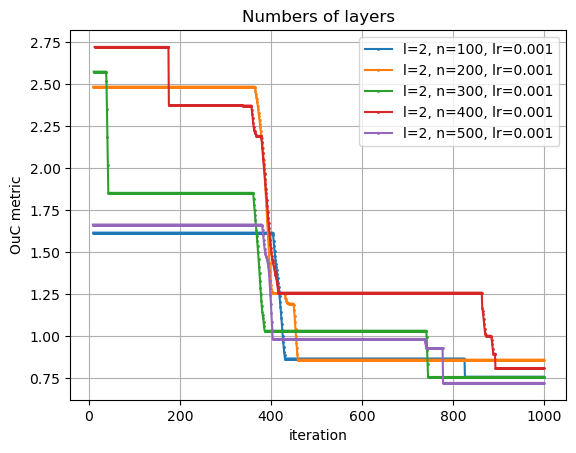

In [58]:
res_neurons = try_neurons([100, 200, 300, 400, 500], 2, 0.001)
plot_results(res_neurons, y_max=10)
plot_result_confrontation(res_neurons)

LAYERS: 5 NEURONS: 500 LR: 0.0001 epsilon: 0.9595935 MSE solution: 0.03728777527885092
LAYERS: 5 NEURONS: 500 LR: 0.001 epsilon: 0.9471026 MSE solution: 0.04178399093389711
LAYERS: 5 NEURONS: 500 LR: 0.01 epsilon: 0.73027664 MSE solution: 0.01986771255778986
LAYERS: 5 NEURONS: 500 LR: 0.1 epsilon: 0.687533 MSE solution: 0.014608139501066963


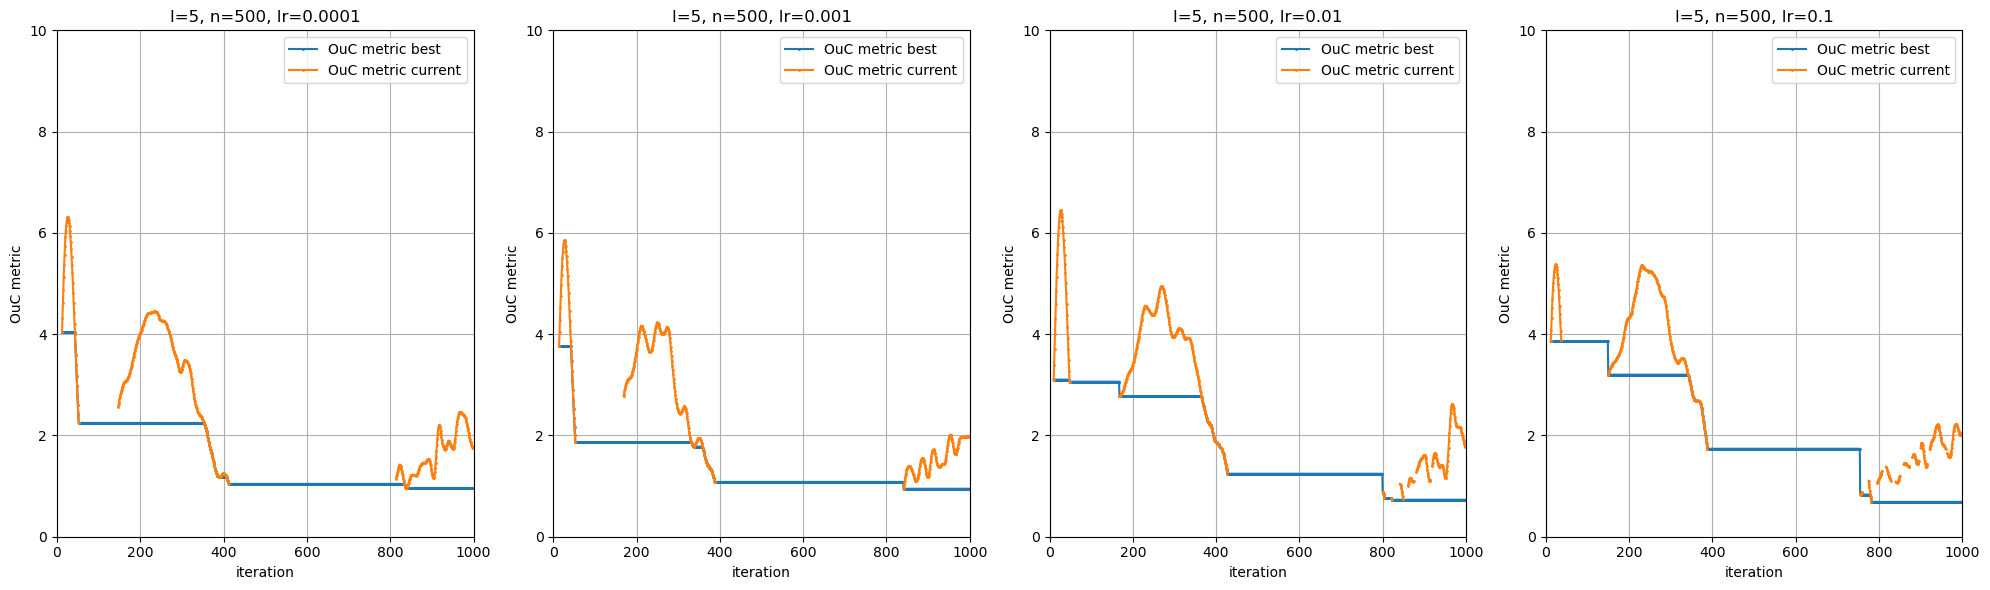

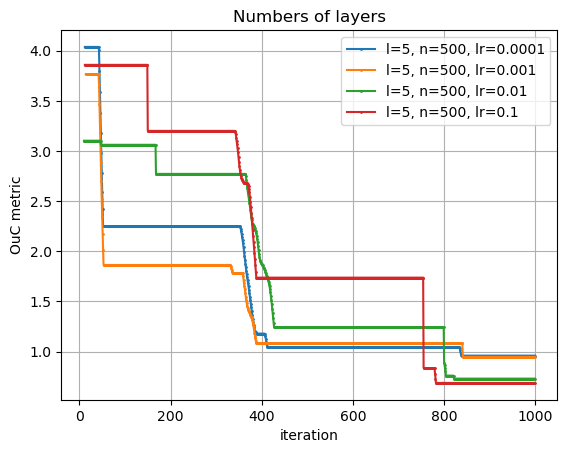

In [59]:
res_learning_rate = try_lr([0.0001, 0.001, 0.01, 0.1], 5, 500)
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)